# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import scipy
from math import pi,acos,log10
import os
import seaborn as sns
from scipy.constants import epsilon_0 as epsilon
%matplotlib inline

In [2]:
#Run this to reset the results
results= pd.DataFrame(columns = ['LC Name', 'Temperature', 'Applied Voltage','Rise Time','Decay Time','Total Response Time','Visco-Elastic Ratio'])

In [3]:
#Loading the data
path="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Electro-optic/Pure" #Enter Loaction WHere CSV data is kept


name_of_LC="Pure"# Change this to show type of LC
thickness= 6E-6 #in Metres
area=64E-6 #in Metres^2
empty_c=94E-12 #in Farad
wavelength=633E-9 #in metre
#Dielectric Anisotropy depends on temperature
#temps=['+2','-1','-2','-3','-5','-7','-9','-11']

voltages=['5','6','7','8','9','10']
#epsilon_a=[1,1,1,1]

if not os.path.exists(path + "/Analysis") :
    os.mkdir (path + "/Analysis")
output_path=path+"/Analysis"

# Finding the Threshold Voltage

In [ ]:
#Reading the datafile containing the Threshold Voltage data
vthdata=pd.read_csv(path+"/Doped_Voltage transmission_RT.csv",skiprows=0)
#vthdata.columns(['Voltage','Intensity'])
#Normalizing Voltage
#vthdata=vthdata.rename(columns={"v":"Voltage","intensity":"Intensity"})
vthdata['Intensity']=(vthdata['Intensity']-vthdata['Intensity'].min())/(vthdata['Intensity'].max()-vthdata['Intensity'].min())

vthdata

In [ ]:
#Plotting the normalized intensity vs voltage data
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.ylabel("Normalized Intensity")
plt.xlabel("Applied Voltage (in Volts)")
plt.plot(vthdata['Voltage'],vthdata['Intensity'],'-o')
#indx_max = np.argmax(vthdata['Intensity'])
#Set on your own
indx_max = 45
plt.plot(vthdata['Voltage'][indx_max], vthdata['Intensity'][indx_max], 'ro')
vth=vthdata['Voltage'][indx_max]
#plt.plot(vth*np.ones(2),[1,vthdata['Intensity'][indx_max]])
plt.annotate("Threshold Votage:"+ str(vth)+'V',(vthdata['Voltage'][indx_max], vthdata['Intensity'][indx_max]),xytext=(vthdata['Voltage'][indx_max]+0.25, vthdata['Intensity'][indx_max]))
print("Threshold Votage:"+ str(vth)+'V')
plt.title(name_of_LC+" Threshold_Voltage")
plt.savefig(output_path+"/"+name_of_LC+"_"+"Threshold_Voltage.jpg", dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
#FInding the birefringence from the Intensity vs Voltage Data
#Threshold Voltage depends on temperature of material
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.ylabel("Degradation in terms of Birefringence")
plt.xlabel("Applied Voltage (in Volts)")
biref=np.arccos(1-vthdata['Intensity']*2)/2/pi/thickness*wavelength
plt.plot(vthdata['Voltage'],biref,'-o')

#indx_max = np.argmax(biref)
#plt.plot(vthdata['Voltage'][indx_max], biref[indx_max], 'ro')
#b=biref[indx_max]
#plt.plot(vth*np.ones(2),[1,vthdata['Intensity'][indx_max]])
#plt.annotate("Max Birefringence:"+ str(b),(vthdata['Voltage'][indx_max], biref[indx_max]),xytext=(vthdata['Voltage'][indx_max]+0.25, biref[indx_max]))
#print("Max Birefrigence:"+ str(b)+'V')

plt.title(name_of_LC+" Birefringence")
plt.savefig(output_path+"/"+name_of_LC+"_"+"Birefringence.jpg", dpi=300,bbox_inches='tight')
plt.show()

# Analysis of Each Temperature and Voltage Case

In [ ]:
if not os.path.exists(output_path+"/TransmittancevsTime") :
    temp=0
    os.mkdir (output_path+"/TransmittancevsTime")
    for voltage in voltages:
        try :
            #temp=str(temp)
            #voltage=str(voltage)
            if voltage=='10':
                input_path=path+"/"+voltage+"_2.csv"
            else:
                input_path=path+"/"+voltage+"__2.csv"
            df=pd.read_csv(input_path,skiprows=1)
            #Normalizing the Volt to represent transmittance
            df.Volt=(df.Volt-df.Volt.min())/(df.Volt.max()-df.Volt.min())
        except :
            print ("Incorrect CSV directory or filename")
            continue
        else:
            print("File Exists. Start Analysis")
        plt.figure(figsize=(12, 8), dpi=100, linewidth=0.1)
        plt.xlabel("Time (in seconds)")
        plt.ylabel("Transmittance")

        #Have set the window size as a constant = 33. If the number of intersections on
        #the 0.9 line or 0.1 line are more than 6, then icncrease window size
        window_size =33
        smooth=savgol_filter(df.Volt,window_size,2) #Creating a smoothened Curve us SavGol filter with window size 25 

        plt.plot(df.second,smooth) #Printing the smooth curve
        plt.plot(df.second,df.Volt)#Printing the actual curve

        plt.plot(df.second,0.9*np.ones(df.second.shape)) #Printing horizontal line at 0.9
        plt.plot(df.second,0.1*np.ones(df.second.shape)) #Printing horizontal line at 0.1

        #Finding position where the curve closses the 0.9 transmittance
        idx = np.argwhere(np.diff(np.sign(smooth - 0.9))).flatten()
        if(len(idx)!=6):
            print("Error in top. Number of points greater than 6. Increase window size and retry")
            exit(1)
        idx=idx[1:5] #Eliminating First and last points
        plt.plot(df.second[idx], 0.9*np.ones(idx.size), 'ro') #Plotting Points of intersection
        #print(len(idx))
        idx_top=idx
        for i in range(len(idx)):
            plt.annotate("T90="+str(round(df.second[idx[i]],4)),(df.second[idx[i]], 0.9),xytext =(df.second[idx[i]]+0.0005-max(0,0.006*pow(-1,i+1)), 0.91))


        #Finding position where the curve closses the 0.1 transmittance
        idx = np.argwhere(np.diff(np.sign(smooth - 0.1))).flatten()
        if(len(idx)!=6):
            print("Error in bot. Number of points greater than 6. Increase window size and retry")
            exit(1)
        idx=idx[1:5] #Eliminating First and last points
        plt.plot(df.second[idx], 0.1*np.ones(idx.size), 'bo') #Plotting Points of intersection
        #print(len(idx))
        idx_bot=idx
        for i in range(len(idx)):
            plt.annotate("T10="+str(round(df.second[idx[i]],4)),(df.second[idx[i]], 0.1),xytext =(df.second[idx[i]]+0.0005-max(0,0.006*pow(-1,i)), 0.11-max(0,0.05*pow(-1,i))))

        #Calculating RiseTime and DecayTime (average of 2 sets)
        rise_time=((df.second[idx_bot[0]]-df.second[idx_top[0]])+(df.second[idx_bot[2]]-df.second[idx_top[2]]))/2
        decay_time=((df.second[idx_top[1]]-df.second[idx_bot[1]])+(df.second[idx_top[3]]-df.second[idx_bot[3]]))/2
        response_time=rise_time+decay_time
        #Printing the times
        #print("Rise Time = ",rise_time,"seconds")
        #print("Decay Time = ",decay_time,"seconds")
        #print("Response Time = ",response_time,"seconds")
        plt.annotate("Rise Time = "+str(round(rise_time,4)),xy=(0.019,1))
        plt.annotate("Decay Time="+str(round(decay_time,4)),xy=(0.019,0.97))
        plt.annotate("Resp. Time="+str(round(response_time,4)),xy=(0.019,0.94))
        plt.annotate(name_of_LC,xy=(-0.027,1))
        plt.annotate("Appl. Volt. = "+voltage+"V",xy=(-0.027,0.97))
        #plt.annotate("Temp = "+temp+"C",xy=(-0.027,0.94))
        plt.title(name_of_LC+"_"+voltage+"V")
        plt.savefig(output_path+"/TransmittancevsTime/"+voltage+".jpg", dpi=300,bbox_inches='tight')
        #plt.show()
        results=results.append({'LC Name':name_of_LC, 'Temperature':temp, 'Applied Voltage':voltage,'Rise Time':rise_time,'Decay Time':decay_time,'Total Response Time': response_time,'Visco-Elastic Ratio':decay_time*(pi/thickness)**2},ignore_index=True)
        

In [ ]:
#If you are happy with the results, you can write it to a csv file.
results.to_csv(output_path+"/"+"RespTimevsAppVolt.csv", index=False)

In [ ]:
results=pd.read_csv(output_path+"/RespTimevsAppVolt.csv")
results.tail()

In [ ]:
#Plotting the response time vs Applied Voltage
if not os.path.exists(output_path+"/ResponseTimevsTemp") :
    os.mkdir (output_path+"/ResponseTimevsTemp")
temps=['0']
for idx,temp in enumerate(temps):
    plt.figure(1,figsize=(12, 8), dpi=100, linewidth=0.1)
    plt.ylabel("Time (in seconds)")
    plt.xlabel("Applied Voltage (in Volts)")
    plt.plot(results['Applied Voltage'][idx*len(voltages):(idx+1)*len(voltages)],results['Total Response Time'][idx*len(voltages):(idx+1)*len(voltages)],'-o')
    plt.plot(results['Applied Voltage'][idx*len(voltages):(idx+1)*len(voltages)],results['Rise Time'][idx*len(voltages):(idx+1)*len(voltages)],'-o')
    plt.plot(results['Applied Voltage'][idx*len(voltages):(idx+1)*len(voltages)],results['Decay Time'][idx*len(voltages):(idx+1)*len(voltages)],'-o')
    plt.legend(['Total Response Time','Rise Time','Decay Time'])
    plt.title(name_of_LC+" - Response Time vs Voltage")
    plt.savefig(output_path+"/ResponseTimevsTemp/"+name_of_LC+"_"+temp+".jpg", dpi=300,bbox_inches='tight')
    plt.show()


In [ ]:
titles=['Rise Time','Decay Time','Total Response Time']
if not os.path.exists(output_path+"/ResponseTimeMap") :
    os.mkdir (output_path+"/ResponseTimeMap")
for title in titles:
    plt.figure(1,figsize=(12, 2), dpi=100, linewidth=0.1)
    teste = np.resize((results[title]*1000).to_numpy(copy=True),(len(temps),len(voltages)))
    tas=pd.DataFrame(teste,temps,voltages)
    sns.heatmap(tas, annot=True,cmap='coolwarm')
    plt.xlabel("Applied Voltage (in Volts)")
    #plt.ylabel("Temperature (in Celcius)")
    plt.title(name_of_LC+" - "+title+" (in ms)")
    plt.savefig(output_path+"/ResponseTimeMap/"+name_of_LC+"_"+title+".jpg", dpi=300,bbox_inches='tight')
    plt.show()


In [ ]:
pure_path="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Electro-optic/Pure/Analysis"
Pure=pd.read_csv(pure_path+"/RespTimevsAppVolt.csv")

doped_path="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Electro-optic/Doped/Analysis"
Doped=pd.read_csv(doped_path+"/RespTimevsAppVolt.csv")

In [ ]:
#Plotting the rise time vs Applied Voltage
outtt="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Electro-optic"
temps=['0']
for idx,temp in enumerate(temps):
    plt.figure(1,figsize=(12, 8), dpi=100, linewidth=0.1)
    plt.ylabel("Time (in seconds)")
    plt.xlabel("Applied Voltage (in Volts)")
    plt.plot(Pure['Applied Voltage'][idx*len(voltages):(idx+1)*len(voltages)],Pure['Rise Time'][idx*len(voltages):(idx+1)*len(voltages)],'-o')
    plt.plot(Doped['Applied Voltage'][idx*len(voltages):(idx+1)*len(voltages)],Doped['Rise Time'][idx*len(voltages):(idx+1)*len(voltages)],'-o')
    plt.legend(['Pure','Doped'])
    plt.title("Pure vs Doped Rise Time")
    plt.savefig(outtt+"/PurevsDoped_RiseTime.jpg", dpi=300,bbox_inches='tight')
    plt.show()


In [ ]:
#Plotting the decay time vs Applied Voltage
outtt="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Electro-optic"
temps=['0']
for idx,temp in enumerate(temps):
    plt.figure(1,figsize=(12, 8), dpi=100, linewidth=0.1)
    plt.ylabel("Time (in seconds)")
    plt.xlabel("Applied Voltage (in Volts)")
    plt.plot(Pure['Applied Voltage'][idx*len(voltages):(idx+1)*len(voltages)],Pure['Decay Time'][idx*len(voltages):(idx+1)*len(voltages)],'-o')
    plt.plot(Doped['Applied Voltage'][idx*len(voltages):(idx+1)*len(voltages)],Doped['Decay Time'][idx*len(voltages):(idx+1)*len(voltages)],'-o')
    plt.legend(['Pure','Doped'])
    plt.title("Pure vs Doped Decay Time")
    plt.savefig(outtt+"/PurevsDoped_DecayTime.jpg", dpi=300,bbox_inches='tight')
    plt.show()


In [ ]:
#Plotting the response time vs Applied Voltage
outtt="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Electro-optic"
temps=['0']
for idx,temp in enumerate(temps):
    plt.figure(1,figsize=(12, 8), dpi=100, linewidth=0.1)
    plt.ylabel("Time (in seconds)")
    plt.xlabel("Applied Voltage (in Volts)")
    plt.plot(Pure['Applied Voltage'][idx*len(voltages):(idx+1)*len(voltages)],Pure['Total Response Time'][idx*len(voltages):(idx+1)*len(voltages)],'-o')
    plt.plot(Doped['Applied Voltage'][idx*len(voltages):(idx+1)*len(voltages)],Doped['Total Response Time'][idx*len(voltages):(idx+1)*len(voltages)],'-o')
    plt.legend(['Pure','Doped'])
    plt.title("Pure vs Doped Response Time")
    plt.savefig(outtt+"/PurevsDoped_ResponseTime.jpg", dpi=300,bbox_inches='tight')
    plt.show()


# Dilelectric Analysis

In [4]:
result_DE= pd.DataFrame(columns = ['LC Name', 'Temperature','e_infi','e_stat','Dielectric_Strength','Relaxation_freq','Relaxation_time'])

In [5]:
# Cofiguration for Pure Sample

name_of_LC="Pure"# Change this to show type of LC
thickness= 6E-6 #in Metres
area=64E-6 #in Metres^2
empty_c=94E-12 #in Farad
temps=['+2','-1','-2','-3','-5','-7','-9','-11']
correct_idx = [0,0,0,2,2,0,0,1]
offsets=[0,0,0,800,800,0,0,800]
base_temp=45.2
path_DE="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/Pure"
if not os.path.exists(path_DE + "/Analysis") :
    os.mkdir (path_DE + "/Analysis")
output_path_DE=path_DE+"/Analysis"

In [ ]:
# Configuration for Doped Sample

name_of_LC="Doped"# Change this to show type of LC
thickness= 6.5E-6 #in Metres
area=70E-6 #in Metres^2
empty_c=102E-12 #in Farad
temps=['+5','+2','-1','-2','-3','-5','-7','-9','-11','-13']
correct_idx = [0,0,0,0,0,0,0,1,0,0]
offsets=[0,0,0,0,0,0,0,800,0,0]
base_temp=44.2
path_DE="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/Doped"
if not os.path.exists(path_DE + "/Analysis") :
    os.mkdir (path_DE + "/Analysis")
output_path_DE=path_DE+"/Analysis"

In [ ]:
#For loop over the temperature range (Run separately for pure and doped)
for temp_idx,filename in enumerate(temps): 
    DE=pd.read_csv(path_DE+"/"+filename+".CSV",skiprows=4)
    DE=DE[:-1]
    DE.columns=['Frequency','Capacitance','Dielectric_loss','Resistance','Reactance','Impedance']
    DE=DE.astype('float64')

    # Changing frequency to log scale 
    #DE.Frequency=np.log10(DE.Frequency)

    # Set endfreq as the frequency value where the Capacitance goes below zero. The other option is to set it to a constant value
    endfreq=pd.Series(DE.Frequency[DE.Capacitance<0]).iloc[correct_idx[temp_idx]]#index to control
    #endfreq=9000000
    print(endfreq)
    DE=DE[DE.Frequency<endfreq]

    real_e=pd.Series(DE.Capacitance*thickness/epsilon/area)
    imag_e =real_e*DE.Dielectric_loss


    #Set the startfreq an the frequency value where the imag_e crosses the x-axis(has +ve value). The other option is to set it to a constant value
    startfreq=DE.Frequency[(imag_e.idxmin())+offsets[temp_idx]]#offset to control
    #startfreq = 2000
    print(startfreq)
    DE=DE[DE.Frequency>startfreq]


    #Recalculating real_e and imag_e in the correct frequency range(where both have +ve values)
    real_e=pd.Series(DE.Capacitance*thickness/epsilon/area)
    imag_e =real_e*DE.Dielectric_loss


    #Finding freq. value of intersection of real_e and imag_e
    idx = np.argwhere(np.diff(np.sign(real_e - imag_e))).flatten()
    idx=idx[0]
    print(idx)

    #Finding freq. value where the imag_e is highest 
    idx1=np.argmax(imag_e)
    print(idx1)

    print(min(real_e),max(real_e))


    #Plotting of figures
    #Collection of real_e vs Frequency for different temperatures
    plt.figure(1,figsize=(12, 8), dpi=100, linewidth=0.1)
    plt.ylabel("Real Permitivity")
    plt.xlabel("Frequency in Hz")
    plt.xlim([1000,10000000])
    plt.ylim([0,10])
    plt.plot(DE.Frequency,real_e)
    plt.title(name_of_LC+" : "+"Real Permitivity vs Frequency")
    #Collecting until displaying
    if(filename==temps[-1]):
        if not os.path.exists(output_path_DE + "/Permitivity_VS_Frequency") :
            os.mkdir (output_path_DE + "/Permitivity_VS_Frequency")
        plt.legend(temps,title="T-T_NI")
        plt.savefig(output_path_DE+"/Permitivity_VS_Frequency/"+"all_temps_real"+".jpg", dpi=300,bbox_inches='tight')

    #Collection of imag_e vs Frequency for different temperatures
    plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
    plt.ylabel("Imaginary Permitivity")
    plt.xlabel("Frequency in Hz")
    plt.xlim([1000,10000000])
    plt.ylim([0,10])
    plt.plot(DE.Frequency,imag_e)
    plt.title(name_of_LC+" : "+"Imaginary Permitivity vs Frequency")
    #Collecting until displaying
    if(filename==temps[-1]):
        if not os.path.exists(output_path_DE + "/Permitivity_VS_Frequency") :
            os.mkdir (output_path_DE + "/Permitivity_VS_Frequency")
        plt.legend(temps,title="T-T_NI")
        plt.savefig(output_path_DE+"/Permitivity_VS_Frequency/"+"all_temps_imag"+".jpg", dpi=300,bbox_inches='tight')

    #Collection of Cole-Cole Plots
    plt.figure(3,figsize=(12, 8), dpi=100, linewidth=0.1)
    plt.ylabel("Imaginary Permitivity")
    plt.xlabel("Real Permitivity")
    plt.xlim([0,10])
    plt.ylim([0,10])
    plt.plot(real_e,imag_e)
    plt.title(name_of_LC+" : Cole-Cole Plots")
    #Collecting until displaying
    if(filename==temps[-1]):
        if not os.path.exists(output_path_DE + "/Cole-Cole_Plot") :
            os.mkdir (output_path_DE + "/Cole-Cole_Plot")
        plt.legend(temps,title="T-T_NI")
        plt.savefig(output_path_DE+"/Cole-Cole_Plot/"+"all_temps_cole_cut"+".jpg", dpi=300,bbox_inches='tight')


    # real_e and imag_e vs frequency for an individual temperature
    plt.figure(figsize=(12, 8), dpi=100, linewidth=0.1)
    plt.ylabel("Permitivity")
    plt.xlabel("Frequency in Hz")
    plt.xlim([1000,10000000])
    plt.ylim([0,10])
    plt.plot(DE.Frequency,real_e)
    plt.plot(DE.Frequency,imag_e)
    plt.plot(DE.Frequency.iloc[idx1], imag_e.iloc[idx1], 'ro')
    plt.annotate("Relaxation Frequency = "+str(round(DE.Frequency.iloc[idx1],2))+"Hz",(DE.Frequency.iloc[idx1], imag_e.iloc[idx1]),xytext =(DE.Frequency.iloc[idx1+5], imag_e.iloc[idx1]))
    plt.title(name_of_LC+" : T-T_NI = "+filename+"C Permitivity vs Frequency")
    plt.legend(['Real Component','Imaginary Component'])
    if not os.path.exists(output_path_DE + "/Permitivity_VS_Frequency") :
        os.mkdir (output_path_DE + "/Permitivity_VS_Frequency")
    plt.savefig(output_path_DE+"/Permitivity_VS_Frequency/"+filename+".jpg", dpi=300,bbox_inches='tight')

    # Cole-Cole Plot for an individual temperature
    plt.figure(figsize=(12, 8), dpi=100, linewidth=0.1)
    plt.xlabel("Real Permitivity")
    plt.ylabel("Imaginary Permitivity")
    plt.plot(real_e,imag_e)

    #plt.plot(real_e,imag_e.iloc[idx1]*np.ones(len(DE.index)),'--')
    # Plotting relaxation frequency on Cole-Cole plot
    plt.plot(real_e.iloc[idx1],imag_e.iloc[idx1], 'ro')
    plt.annotate("Relaxation Frequency = "+str(round(DE.Frequency.iloc[idx1],2))+"Hz",(real_e.iloc[idx1],imag_e.iloc[idx1]),xytext =(real_e.iloc[idx1],imag_e.iloc[idx1]+0.1))
    minn=np.argmin(imag_e)
    plt.plot(real_e.iloc[minn], imag_e.iloc[minn], 'ro')#e_static
    plt.annotate("e_static = "+str(round(real_e.iloc[minn],4)),(real_e.iloc[minn], imag_e.iloc[minn]),xytext =(real_e.iloc[minn]-1, imag_e.iloc[minn]-0.2))
    plt.plot(real_e.iloc[-1], imag_e.iloc[-1], 'ro')#e_infinity
    plt.xlim([0,10])
    plt.ylim([0,10])
    plt.annotate("e_infinity = "+str(round(real_e.iloc[-1],4)),(real_e.iloc[-1], imag_e.iloc[-1]),xytext =(real_e.iloc[-1], imag_e.iloc[-1]-0.2))
    plt.title(name_of_LC+" : T-T_NI = "+filename+"C Cole-Cole Plot")
    if not os.path.exists(output_path_DE + "/Cole-Cole_Plot") :
        os.mkdir (output_path_DE + "/Cole-Cole_Plot")
    plt.savefig(output_path_DE+"/Cole-Cole_Plot/"+filename+".jpg", dpi=300,bbox_inches='tight')

    #Storing results in results_DE
    result_DE=result_DE.append({'LC Name':name_of_LC, 'Temperature':base_temp+int(filename), 'e_infi':real_e.iloc[-1],'e_stat':real_e.iloc[0],'Dielectric_Strength':real_e.iloc[0]-real_e.iloc[-1],'Relaxation_freq': DE.Frequency.iloc[idx1],'Relaxation_time':1/DE.Frequency.iloc[idx1]/2/pi},ignore_index=True)

In [ ]:
#result_DE=result_DE.append({'LC Name':name_of_LC, 'Temperature':filename, 'e_infi':real_e.iloc[-1],'e_stat':real_e.iloc[0],'Dielectric_Strength':real_e.iloc[0]-real_e.iloc[-1],'Relaxation_freq': DE.Frequency.iloc[idx1],'Relaxation_time':1/DE.Frequency.iloc[idx1]},ignore_index=True)
result_DE

In [ ]:
#Writing results to csv
result_DE.to_csv(output_path_DE+"/"+"Dielectric_Data.csv", index=False)

In [ ]:
#Reading the values from the results stored in a csv file.
result_DE=pd.read_csv(output_path_DE+"/Dielectric_Data.csv")
result_DE

# Curve Fitting

In [32]:
#f0=8422276.260
def EQ1(f,alpha,beta):
    return e_infi+ds*((1-1j*f/(f0**alpha))**(-beta/alpha))
def EQ2(f,alpha,beta):
    return e_infi+ds*((1+(-1j*f/f0)**alpha)**(-beta))

def complex_res(f,f0,alpha,beta):
    z=complex(1,f/(f0**alpha))
    return ((z**(-beta/alpha)).imag)

def complex_res_real(f,f0,alpha,beta):
    z=complex(1,f/(f0**alpha))
    return ((z**(-beta/alpha)).real)

def complex_HN_imag(f,f0,alpha,beta):
    z1=complex(0,-f/f0)
    z2=z1**alpha
    z2=complex(z2.real+1,z2.imag)
    return ((z2**-beta).imag)

def complex_HN_real(f,f0,alpha,beta):
    z1=complex(0,-f/f0)
    z2=z1**alpha
    z2=complex(z2.real+1,z2.imag)
    return ((z2**-beta).real)

def complex_res_array(f,alpha,beta):
    sim=np.zeros(len(f.index))
    #set on your own
    #f0=8496499.798
    for i in range(len(f.index)):
        sim[i]=complex_res(f.iloc[i],f0,alpha,beta)
    sim*=-1
    return sim

def complex_res_real_array(f,alpha,beta):
    sim=np.zeros(len(f.index))
    #set on your own
    #f0=8496499.798
    for i in range(len(f.index)):
        sim[i]=complex_res_real(f.iloc[i],f0,alpha,beta)
    #sim*=-1
    return sim

def complex_HN_imag_array(f,alpha,beta):
    sim=np.zeros(len(f.index))
    #set on your own
    #f0=8496499.798
    for i in range(len(f.index)):
        sim[i]=complex_HN_imag(f.iloc[i],f0,alpha,beta)
    #sim*=-1
    return sim

def complex_HN_real_array(f,alpha,beta):
    sim=np.zeros(len(f.index))
    #set on your own
    #f0=8496499.798
    for i in range(len(f.index)):
        sim[i]=complex_HN_real(f.iloc[i],f0,alpha,beta)
    #sim*=-1
    return sim

def complex_res_array_real(f,alpha,beta):
    sim=np.zeros(len(f.index))
    #set on your own
    #f0=8496499.798
    for i in range(len(f.index)):
        sim[i]=complex_res(f.iloc[i],f0,alpha,beta)
    sim*=-1
    sim/=DE.Dielectric_loss
    return sim

def sq_error(params):
    alpha,beta=params
    return np.sum(np.sqrt((imag_e-complex_res_array(DE.Frequency,alpha,beta))**2+(real_e-complex_res_real_array(DE.Frequency,alpha,beta))**2))


In [33]:
# Attempt to fit curve to cole-cole plot and estimating values of alpha and beta

filename='-11'

DE=pd.read_csv(path_DE+"/"+filename+".CSV",skiprows=4)
DE=DE[:-1]
DE.columns=['Frequency','Capacitance','Dielectric_loss','Resistance','Reactance','Impedance']
DE=DE.astype('float64')

#DE.Frequency=np.log10(DE.Frequency)

endfreq=pd.Series(DE.Frequency[DE.Capacitance<0]).iloc[1]#index to control
#endfreq=10000000
print("End Freq = ",endfreq)
DE=DE[DE.Frequency<endfreq]

real_e=pd.Series(DE.Capacitance*thickness/epsilon/area)
imag_e =real_e*DE.Dielectric_loss

startfreq=DE.Frequency[(imag_e.idxmin())+800]#offset to control
#startfreq = 1000
print("Start Freq = ",startfreq)
DE=DE[DE.Frequency>startfreq]

real_e=pd.Series(DE.Capacitance*thickness/epsilon/area)
imag_e =real_e*DE.Dielectric_loss

conductivity=DE.
####################################
# # Export Freq, Real_e and Imag_e to csv file
# frame = { 'Frequency': DE.Frequency, 'Real': real_e, 'Imaginary': imag_e } 
  
# RS = pd.DataFrame(frame) 
# print(RS)
# RS.to_csv(output_path_DE+"/"+"Fitting_Data.csv", index=False)
#######################################

# idx = np.argwhere(np.diff(np.sign(real_e - imag_e))).flatten()
# idx=idx[0]
# print(idx)

idx1=np.argmax(imag_e)
f0=DE.Frequency.iloc[idx1]
print("Relaxation Freq = ", f0)
alpha =1
print("Alpha = ", alpha)
beta=1
print("Beta = ", beta)
e_stat=real_e.iloc[0]
e_stat=5.79901962 
print("e_static = ",e_stat)
e_infi=real_e.iloc[-1]
e_infi=-0.42371239
print("e_static = ",e_infi)
ds=e_stat-e_infi
print("Dielectric strength = ",ds)


#print(range(len(DE.index)))

sim_real = complex_HN_real_array(DE.Frequency,alpha,beta)*ds+e_infi
sim_imag = complex_res_array(DE.Frequency,alpha,beta)*ds
#print(sim)

############################################################
plt.figure(5,figsize=(6, 4), dpi=100, linewidth=0.1)
plt.xlabel("Real Permitivity")
plt.ylabel("Imaginary Permitivity")
#plt.plot(DE.Frequency,real_e)
plt.plot(real_e,imag_e)
plt.plot(sim_real,sim_imag)
#plt.plot(real_e,imag_e)
#sim=real_e.iloc[-1]+(real_e.iloc[0]-real_e.iloc[-1])*(1+((DE.Frequency/DE.Frequency.iloc[idx1])**(1-alpha))*np.sin(pi/2*alpha))/(1+2*((DE.Frequency/DE.Frequency.iloc[idx1])**(1-alpha))*np.sin(pi/2*alpha)+((DE.Frequency/DE.Frequency.iloc[idx1])**((1-alpha)*2)))

#sim_re=real_e.iloc[-1]+(real_e.iloc[0]-real_e.iloc[-1])/2*(1-np.sinh((1-alpha)*np.log(DE.Frequency/DE.Frequency.iloc[idx1]))/(np.cosh((1-alpha)*np.log(DE.Frequency/#DE.Frequency.iloc[idx1]))+np.cos(alpha*pi/2)))
#plt.plot(DE.Frequency,sim_re)

#sim_ie=(real_e.iloc[0]-real_e.iloc[-1])/2*np.cos(alpha*pi/2)/(np.cosh((1-alpha)*np.log(DE.Frequency/DE.Frequency.iloc[idx1]))+np.sin(alpha*pi/2))
#plt.plot(DE.Frequency,sim_ie)

#plt.plot(sim_re,sim_ie)
plt.title(name_of_LC+" : "+filename+" Curve Fitting")
plt.legend(['Acutal','Simulated'])
if not os.path.exists(output_path_DE + "/Permitivity_VS_Frequency") :
    os.mkdir (output_path_DE + "/Permitivity_VS_Frequency")
#plt.savefig(output_path_DE+"/Permitivity_VS_Frequency/"+filename+"check_alpha.jpg", dpi=300,bbox_inches='tight')

SyntaxError: invalid syntax (<ipython-input-33-248b2c9392a0>, line 28)

# New sample test

In [7]:
from scipy.optimize import curve_fit,minimize

         Frequency     RealE      ImagE     Sigma
0     2.000000e+01  52.72026  269.04192  0.000001
1     2.017300e+01  52.11354  266.71488  0.000001
2     2.034800e+01  51.64803  264.46914  0.000001
3     2.052500e+01  51.13383  262.27517  0.000001
4     2.070300e+01  50.60574  259.99647  0.000001
...            ...       ...        ...       ...
1556  1.370000e+07   0.09636    1.01201  0.000223
1557  1.380000e+07   0.08841    0.99592  0.000221
1558  1.390000e+07   0.08074    0.97991  0.000218
1559  1.400000e+07   0.07316    0.96382  0.000215
1560  1.420000e+07   0.06571    0.94691  0.000213

[1561 rows x 4 columns]
End Freq =  10000000
Start Freq =  20700
Relaxation Freq =  863038.1540000001
Alpha =  1
Beta =  1
e_static =  14.62841
e_static =  0.44348000000000004
Dielectric strength =  14.184930000000001
range(0, 716)


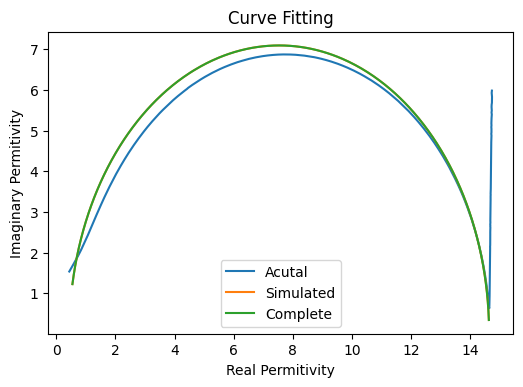

In [36]:
# Attempt to fit curve to cole-cole plot and estimating values of alpha and beta

filename='0.0'

DE=pd.read_csv("/home/avinash/Downloads/"+filename+".csv")
#DE=DE[:-1]
DE.columns=['Frequency','RealE','ImagE','Sigma']
DE=DE.astype('float64')
print(DE)

DE_actual=DE.copy()
# #DE.Frequency=np.log10(DE.Frequency)

endfreq=10000000
print("End Freq = ",endfreq)
DE=DE[DE.Frequency<endfreq]
DE_actual=DE_actual[DE_actual.Frequency<endfreq]


startfreq = 20700
#startfreq = 51700
#startfreq = 40000
#startfreq = 25400
startfreq_actual= 1000
print("Start Freq = ",startfreq)
DE=DE[DE.Frequency>startfreq]
DE_actual=DE_actual[DE_actual.Frequency>startfreq_actual]


#plt.plot(DE.Frequency,DE.RealE)
#plt.plot(DE.Frequency,DE.ImagE)
#plt.plot(DE.RealE,DE.ImagE)



idx1=np.argmax(DE.ImagE)
f0=DE.Frequency.iloc[idx1]
print("Relaxation Freq = ", f0)
alpha =1
print("Alpha = ", alpha)
beta=1
print("Beta = ", beta)
e_stat=DE.RealE.iloc[0]
#e_stat=5.79901962 
print("e_static = ",e_stat)
e_infi=DE.RealE.iloc[-1]
#e_infi=-0.42371239
print("e_static = ",e_infi)
ds=e_stat-e_infi
print("Dielectric strength = ",ds)
real_e=DE.RealE
imag_e=DE.ImagE


print(range(len(DE.index)))

sim_real = complex_HN_real_array(DE.Frequency,alpha,beta)*ds+e_infi
sim_imag = complex_res_array(DE.Frequency,alpha,beta)*ds
sim_complete=EQ1(DE.Frequency,alpha,beta)
############################################################
plt.figure(5,figsize=(6, 4), dpi=100, linewidth=0.1)
plt.xlabel("Real Permitivity")
plt.ylabel("Imaginary Permitivity")
#plt.plot(DE.Frequency,real_e)
plt.plot(DE_actual.RealE,DE_actual.ImagE)
plt.plot(sim_real,sim_imag)
plt.plot(np.real(sim_complete),np.imag(sim_complete))
#plt.plot(real_e,imag_e)
#sim=real_e.iloc[-1]+(real_e.iloc[0]-real_e.iloc[-1])*(1+((DE.Frequency/DE.Frequency.iloc[idx1])**(1-alpha))*np.sin(pi/2*alpha))/(1+2*((DE.Frequency/DE.Frequency.iloc[idx1])**(1-alpha))*np.sin(pi/2*alpha)+((DE.Frequency/DE.Frequency.iloc[idx1])**((1-alpha)*2)))

#sim_re=real_e.iloc[-1]+(real_e.iloc[0]-real_e.iloc[-1])/2*(1-np.sinh((1-alpha)*np.log(DE.Frequency/DE.Frequency.iloc[idx1]))/(np.cosh((1-alpha)*np.log(DE.Frequency/#DE.Frequency.iloc[idx1]))+np.cos(alpha*pi/2)))
#plt.plot(DE.Frequency,sim_re)

#sim_ie=(real_e.iloc[0]-real_e.iloc[-1])/2*np.cos(alpha*pi/2)/(np.cosh((1-alpha)*np.log(DE.Frequency/DE.Frequency.iloc[idx1]))+np.sin(alpha*pi/2))
#plt.plot(DE.Frequency,sim_ie)

#plt.plot(sim_re,sim_ie)
plt.title("Curve Fitting")
plt.legend(['Acutal','Simulated','Complete'])
if not os.path.exists(output_path_DE + "/Permitivity_VS_Frequency") :
    os.mkdir (output_path_DE + "/Permitivity_VS_Frequency")
#plt.savefig(output_path_DE+"/Permitivity_VS_Frequency/"+filename+"check_alpha.jpg", dpi=300,bbox_inches='tight')

[0.98422573 0.96849849]
Cole-Cole Plot error = 6940.709928562012


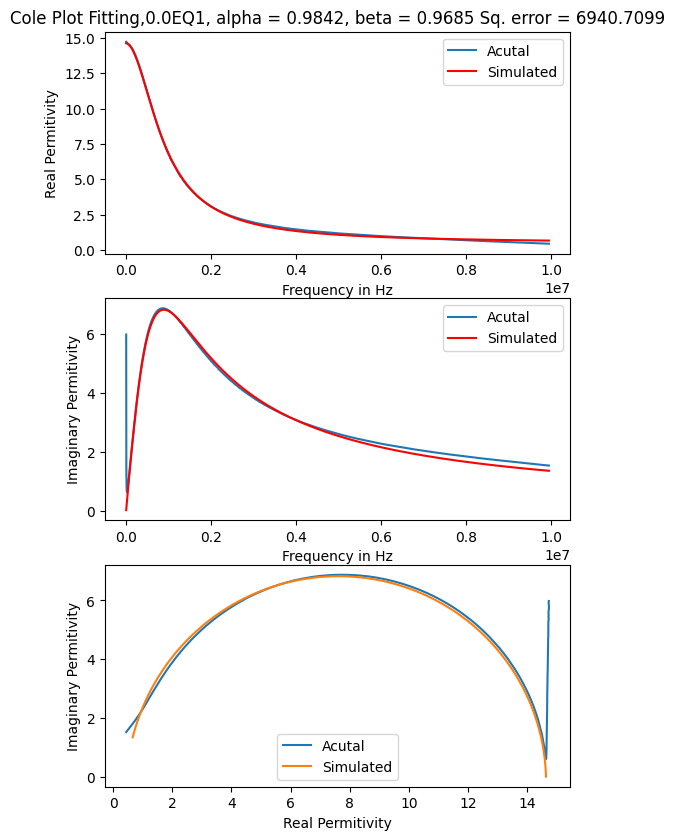

In [37]:
def funcBoth(x, alpha,beta):
    N = len(x)
    x_real = x[:N//2]
    x_imag = x[N//2:]
    y_real = np.real(EQ1(x_real, alpha,beta))
    y_imag = np.imag(EQ1(x_imag, alpha,beta))
    return np.hstack([y_real, y_imag])


# Split the measurements into a  real and imaginary part
yReal = real_e.to_numpy()
yImag = imag_e.to_numpy()
yBoth = np.hstack([yReal, yImag])

x=DE.Frequency.to_numpy()

# Find the best-fit solution
poptBoth, pcovBoth = curve_fit(funcBoth, np.hstack([x, x]), yBoth,p0=[1,1],bounds=([0,0],[1,1]))

# Compute the best-fit solution
yFit = EQ1(x, *poptBoth)
print(poptBoth)

# Plot the results
plt.figure(5,figsize=(6, 10), dpi=100, linewidth=0.1)

#plt.figure(1)
plt.subplot(3,1,1)
plt.title("Cole Plot Fitting,"+filename+"EQ1, alpha = "+str(round(poptBoth[0],4))+", beta = "+str(round(poptBoth[1],4))+" Sq. error = "+str(round(sq_error((poptBoth[0],poptBoth[1])),4)))
plt.ylabel("Real Permitivity")
plt.xlabel("Frequency in Hz")
# plt.plot(DE.Frequency,real_e)
# plt.plot(DE.Frequency, complex_res_real_array(DE.Frequency, *popt)*ds+e_infi, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt))
plt.plot(DE_actual.Frequency,DE_actual.RealE)
plt.plot(DE_actual.Frequency, np.real(EQ1(DE_actual.Frequency,*poptBoth)), 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(poptBoth))
plt.legend(['Acutal','Simulated'])

print("Cole-Cole Plot error = "+str(sq_error((poptBoth[0],poptBoth[1]))))

plt.subplot(3,1,2)
plt.xlabel("Frequency in Hz")
plt.ylabel("Imaginary Permitivity")
# plt.plot(DE.Frequency, imag_e)
# plt.plot(DE.Frequency, complex_res_array(DE.Frequency, *popt)*ds, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt))
plt.plot(DE_actual.Frequency, DE_actual.ImagE)
plt.plot(DE_actual.Frequency, np.imag(EQ1(DE_actual.Frequency,*poptBoth)), 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(poptBoth))
plt.legend(['Acutal','Simulated'])

plt.subplot(3,1,3)
plt.xlabel("Real Permitivity")
plt.ylabel("Imaginary Permitivity")
# sim_real = complex_res_real_array(DE.Frequency,popt[0],popt[1])*ds+e_infi
# sim_imag = complex_res_array(DE.Frequency,popt[0],popt[1])*ds
# plt.plot(DE.RealE,DE.ImagE)
# plt.plot(sim_real,sim_imag)
sim_real = np.real(EQ1(DE_actual.Frequency,*poptBoth))
sim_imag = np.imag(EQ1(DE_actual.Frequency,*poptBoth))
plt.plot(DE_actual.RealE,DE_actual.ImagE)
plt.plot(sim_real,sim_imag)
plt.legend(['Acutal','Simulated'])

In [43]:
from sklearn.metrics import r2_score
print("Real:"+str(r2_score(real_e,np.real(EQ1(DE.Frequency,*poptBoth)))))
print("Imag:"+str(r2_score(imag_e,np.imag(EQ1(DE.Frequency,*poptBoth)))))
print("Cole:"+str(r2_score((real_e,imag_e),(np.real(EQ1(DE.Frequency,*poptBoth)),np.imag(EQ1(DE.Frequency,*poptBoth))))))

Real:0.9998671245197345
Imag:0.9975949507137564
Cole:0.3870246876643633


Cole-Cole Plot error = 5869.944568042098


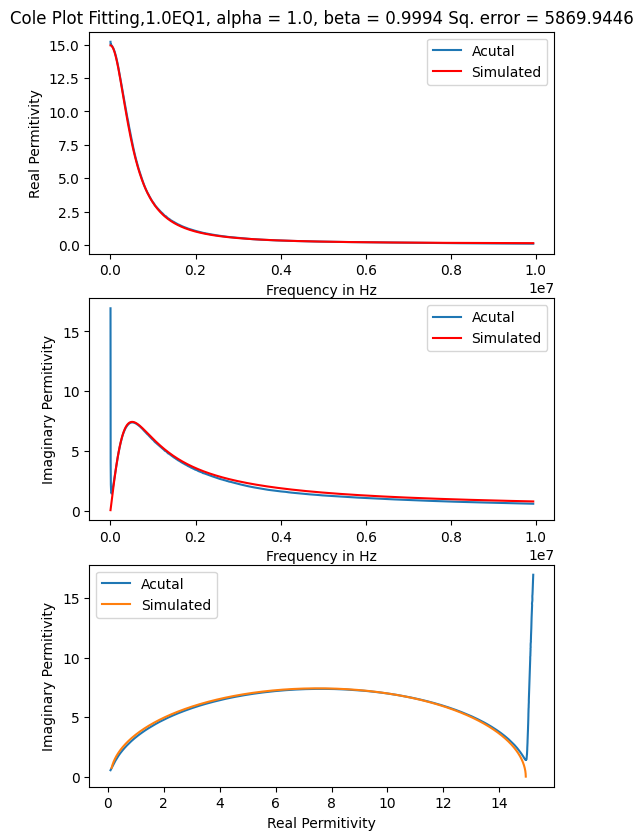

In [36]:
y1 = (real_e-e_infi)/ds
y2 = imag_e/ds
comboY = y1.copy().append(y2)

h = DE.Frequency
comboX = h.copy().append(h)

def comboFunc(comboData, alpha, beta):
    # single data set passed in, extract separate data
    extract1 = comboData[:len(y1)] # first data
    extract2 = comboData[len(y2):] # second data

    result1 = complex_res_real_array(extract1, alpha, beta)
    result2 = complex_res_array(extract2, alpha, beta)

    return np.append(result1, result2)


# some initial parameter values
initialParameters = np.array([1.0, 1.0])

# curve fit the combined data to the combined function
popt, pcov = curve_fit(comboFunc, comboX, comboY, p0=[1,1],bounds=([0,0],[1,1]))

# values for display of fitted function
a, b = popt
sim_real = complex_res_real_array(h, a, b) # first data set, first equation
sim_imag = complex_res_array(h, a, b) # second data set, second equation

plt.figure(5,figsize=(6, 10), dpi=100, linewidth=0.1)

#plt.figure(1)
plt.subplot(3,1,1)
plt.title("Cole Plot Fitting,"+filename+"EQ1, alpha = "+str(round(popt[0],4))+", beta = "+str(round(popt[1],4))+" Sq. error = "+str(round(sq_error((popt[0],popt[1])),4)))
plt.ylabel("Real Permitivity")
plt.xlabel("Frequency in Hz")
# plt.plot(DE.Frequency,real_e)
# plt.plot(DE.Frequency, complex_res_real_array(DE.Frequency, *popt)*ds+e_infi, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt))
plt.plot(DE_actual.Frequency,DE_actual.RealE)
plt.plot(DE_actual.Frequency, complex_res_real_array(DE_actual.Frequency, *popt)*ds+e_infi, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt))
plt.legend(['Acutal','Simulated'])

print("Cole-Cole Plot error = "+str(sq_error((popt[0],popt[1]))))

plt.subplot(3,1,2)
plt.xlabel("Frequency in Hz")
plt.ylabel("Imaginary Permitivity")
# plt.plot(DE.Frequency, imag_e)
# plt.plot(DE.Frequency, complex_res_array(DE.Frequency, *popt)*ds, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt))
plt.plot(DE_actual.Frequency, DE_actual.ImagE)
plt.plot(DE_actual.Frequency, complex_res_array(DE_actual.Frequency, *popt)*ds, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt))
plt.legend(['Acutal','Simulated'])

plt.subplot(3,1,3)
plt.xlabel("Real Permitivity")
plt.ylabel("Imaginary Permitivity")
# sim_real = complex_res_real_array(DE.Frequency,popt[0],popt[1])*ds+e_infi
# sim_imag = complex_res_array(DE.Frequency,popt[0],popt[1])*ds
# plt.plot(DE.RealE,DE.ImagE)
# plt.plot(sim_real,sim_imag)
sim_real = complex_res_real_array(DE_actual.Frequency,popt[0],popt[1])*ds+e_infi
sim_imag = complex_res_array(DE_actual.Frequency,popt[0],popt[1])*ds
plt.plot(DE_actual.RealE,DE_actual.ImagE)
plt.plot(sim_real,sim_imag)
plt.legend(['Acutal','Simulated'])

dict = {'Freq': DE_actual.Frequency, 'Fit_real': sim_real, 'Fit_imag': sim_imag} 
printDF=pd.DataFrame(dict)
printDF.to_csv("/home/avinash/Downloads/"+filename+"-EQ1.csv", index=False)

plt.savefig("/home/avinash/Downloads/"+filename+"-EQ1.jpg",dpi=300,bbox_inches='tight')

[0.99444432 0.90959476]
Cole-Cole Plot error = 6915.529361948978


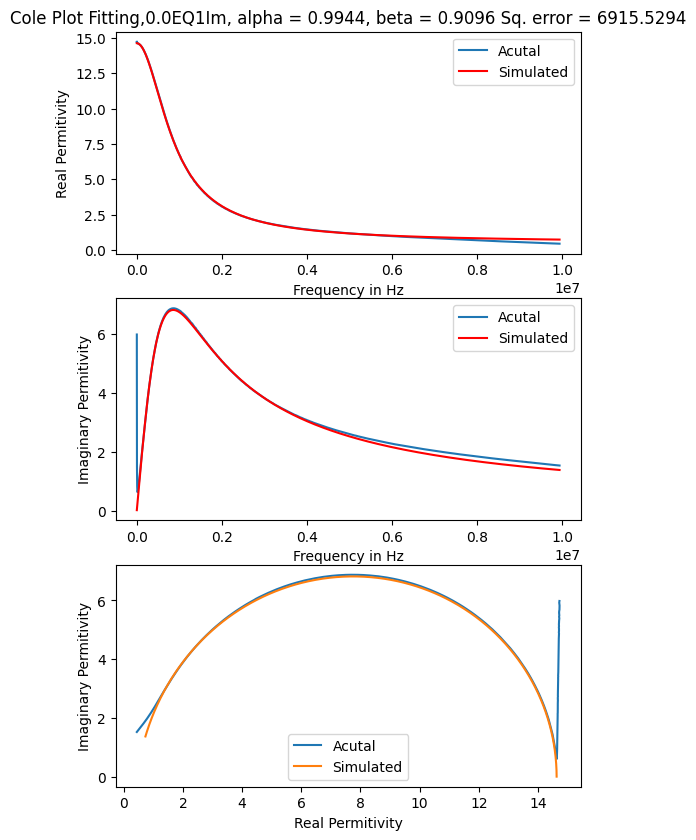

In [10]:
popt, pcov = curve_fit(complex_res_array, DE.Frequency, imag_e/ds,p0=[1,1],bounds=([0,0],[1,1]))
print(popt)
plt.figure(5,figsize=(6, 10), dpi=100, linewidth=0.1)

#plt.figure(1)
plt.subplot(3,1,1)
plt.title("Cole Plot Fitting,"+filename+"EQ1Im, alpha = "+str(round(popt[0],4))+", beta = "+str(round(popt[1],4))+" Sq. error = "+str(round(sq_error((popt[0],popt[1])),4)))
plt.ylabel("Real Permitivity")
plt.xlabel("Frequency in Hz")
# plt.plot(DE.Frequency,real_e)
# plt.plot(DE.Frequency, complex_res_real_array(DE.Frequency, *popt)*ds+e_infi, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt))
plt.plot(DE_actual.Frequency,DE_actual.RealE)
plt.plot(DE_actual.Frequency, complex_res_real_array(DE_actual.Frequency, *popt)*ds+e_infi, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt))
plt.legend(['Acutal','Simulated'])

print("Cole-Cole Plot error = "+str(sq_error((popt[0],popt[1]))))

plt.subplot(3,1,2)
plt.xlabel("Frequency in Hz")
plt.ylabel("Imaginary Permitivity")
# plt.plot(DE.Frequency, imag_e)
# plt.plot(DE.Frequency, complex_res_array(DE.Frequency, *popt)*ds, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt))
plt.plot(DE_actual.Frequency, DE_actual.ImagE)
plt.plot(DE_actual.Frequency, complex_res_array(DE_actual.Frequency, *popt)*ds, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt))
plt.legend(['Acutal','Simulated'])

plt.subplot(3,1,3)
plt.xlabel("Real Permitivity")
plt.ylabel("Imaginary Permitivity")
# sim_real = complex_res_real_array(DE.Frequency,popt[0],popt[1])*ds+e_infi
# sim_imag = complex_res_array(DE.Frequency,popt[0],popt[1])*ds
# plt.plot(DE.RealE,DE.ImagE)
# plt.plot(sim_real,sim_imag)
sim_real = complex_res_real_array(DE_actual.Frequency,popt[0],popt[1])*ds+e_infi
sim_imag = complex_res_array(DE_actual.Frequency,popt[0],popt[1])*ds
plt.plot(DE_actual.RealE,DE_actual.ImagE)
plt.plot(sim_real,sim_imag)
plt.legend(['Acutal','Simulated'])

dict = {'Freq': DE_actual.Frequency, 'Fit_real': sim_real, 'Fit_imag': sim_imag} 
printDF=pd.DataFrame(dict)
printDF.to_csv("/home/avinash/Downloads/"+filename+"-EQ1Im.csv", index=False)

plt.savefig("/home/avinash/Downloads/"+filename+"-EQ1Im.jpg",dpi=300,bbox_inches='tight')


[0.99584056 0.92215877]
Cole-Cole Plot error = 6914.963351137756


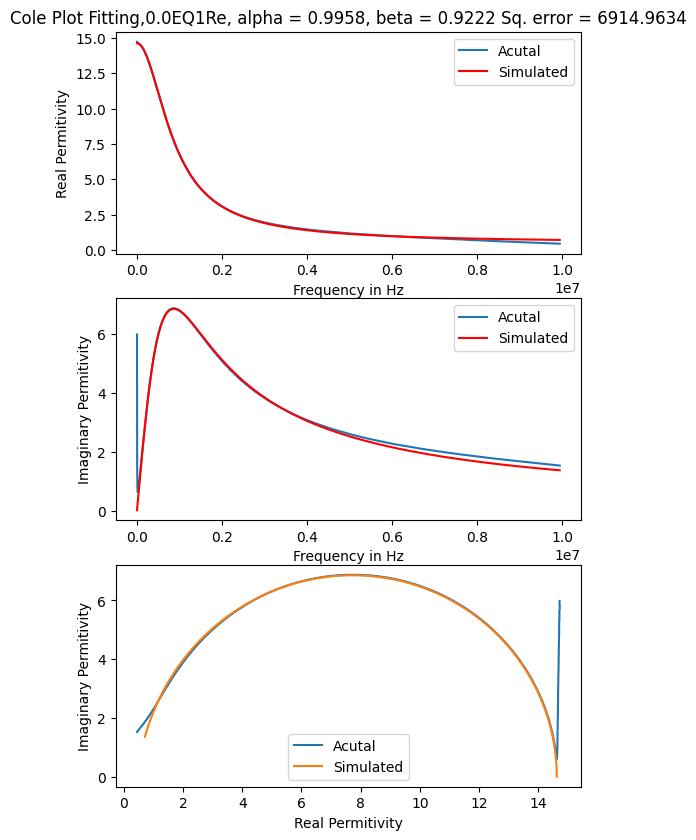

In [11]:
popt_res_real, pcov_res_real = curve_fit(complex_res_real_array, DE.Frequency, (real_e-e_infi)/ds,p0=[1,1],bounds=(0,1))
print(popt_res_real)
plt.figure(5,figsize=(6, 10), dpi=100, linewidth=0.1)

#plt.figure(1)
plt.subplot(3,1,1)
plt.title("Cole Plot Fitting,"+filename+"EQ1Re, alpha = "+str(round(popt_res_real[0],4))+", beta = "+str(round(popt_res_real[1],4))+" Sq. error = "+str(round(sq_error((popt_res_real[0],popt_res_real[1])),4)))
plt.ylabel("Real Permitivity")
plt.xlabel("Frequency in Hz")
plt.plot(DE_actual.Frequency,DE_actual.RealE)
plt.plot(DE_actual.Frequency, complex_res_real_array(DE_actual.Frequency, *popt_res_real)*ds+e_infi, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt_res_real))
#plt.plot(DE.Frequency,real_e)
#plt.plot(DE.Frequency, complex_res_real_array(DE.Frequency, *popt_res_real)*ds+e_infi, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt_res_real))
plt.legend(['Acutal','Simulated'])

print("Cole-Cole Plot error = "+str(sq_error((popt_res_real[0],popt_res_real[1]))))

#plt.figure(6,figsize=(6, 4), dpi=100, linewidth=0.1)
plt.subplot(3,1,2)
plt.xlabel("Frequency in Hz")
plt.ylabel("Imaginary Permitivity")
plt.plot(DE_actual.Frequency, DE_actual.ImagE)
plt.plot(DE_actual.Frequency, complex_res_array(DE_actual.Frequency, *popt_res_real)*ds, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt_res_real))
#plt.plot(DE.Frequency, imag_e)
#plt.plot(DE.Frequency, complex_res_array(DE.Frequency, *popt_res_real)*ds, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt_res_real))
#plt.title("Curve Fitting, alpha = "+str(popt_res_real[0])+", beta = "+str(popt_res_real[1]))
plt.legend(['Acutal','Simulated'])

#plt.figure(6,figsize=(6, 4), dpi=100, linewidth=0.1)
plt.subplot(3,1,3)
plt.xlabel("Real Permitivity")
plt.ylabel("Imaginary Permitivity")
# sim_real = complex_res_real_array(DE.Frequency,popt_res_real[0],popt_res_real[1])*ds+e_infi
# sim_imag = complex_res_array(DE.Frequency,popt_res_real[0],popt_res_real[1])*ds
# plt.plot(DE.RealE,DE.ImagE)
# plt.plot(sim_real,sim_imag)
sim_real = complex_res_real_array(DE_actual.Frequency,popt_res_real[0],popt_res_real[1])*ds+e_infi
sim_imag = complex_res_array(DE_actual.Frequency,popt_res_real[0],popt_res_real[1])*ds
plt.plot(DE_actual.RealE,DE_actual.ImagE)
plt.plot(sim_real,sim_imag)
plt.legend(['Acutal','Simulated'])

#dict = {'Freq': DE.Frequency, 'Fit_real': sim_real, 'Fit_imag': sim_imag} 
dict = {'Freq': DE_actual.Frequency, 'Fit_real': sim_real, 'Fit_imag': sim_imag} 
printDF=pd.DataFrame(dict)
printDF.to_csv("/home/avinash/Downloads/"+filename+"-EQ1Re.csv", index=False)

plt.savefig("/home/avinash/Downloads/"+filename+"-EQ1Re.jpg",dpi=300,bbox_inches='tight')



#plt.legend(['Acutal','Simulated'])

[0.97810605 0.97997219]
Cole-Cole Plot error = 6953.339659046903


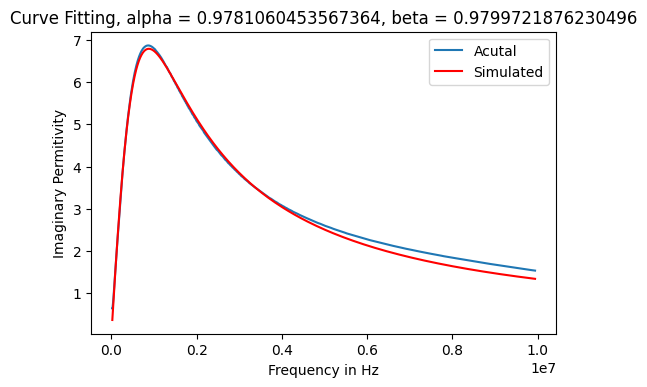

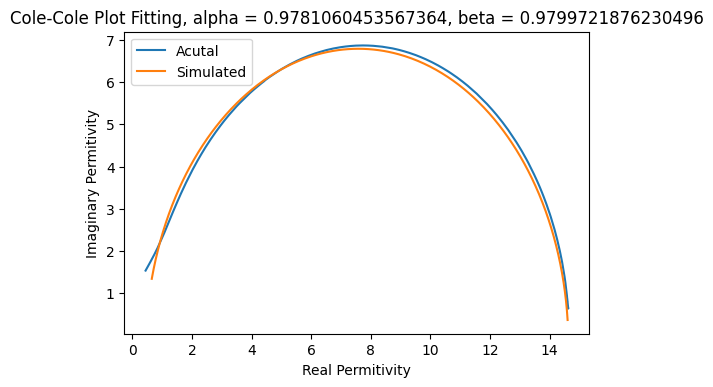

In [12]:
popt_HN_imag, pcov_HN_imag = curve_fit(complex_HN_imag_array, DE.Frequency, (imag_e)/ds,p0=[1,1],bounds=(0,1))
print(popt_HN_imag)
plt.figure(5,figsize=(6, 4), dpi=100, linewidth=0.1)
plt.ylabel("Imaginary Permitivity")
plt.xlabel("Frequency in Hz")
plt.plot(DE.Frequency,imag_e)
plt.plot(DE.Frequency, complex_HN_imag_array(DE.Frequency, *popt_HN_imag)*ds, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt_HN_imag))
plt.title("Curve Fitting, alpha = "+str(popt_HN_imag[0])+", beta = "+str(popt_HN_imag[1]))
plt.legend(['Acutal','Simulated'])
print("Cole-Cole Plot error = "+str(sq_error((popt_HN_imag[0],popt_HN_imag[1]))))

plt.figure(6,figsize=(6, 4), dpi=100, linewidth=0.1)
plt.xlabel("Real Permitivity")
plt.ylabel("Imaginary Permitivity")
sim_real = complex_HN_real_array(DE.Frequency,popt_HN_imag[0],popt_HN_imag[1])*ds+e_infi
sim_imag = complex_HN_imag_array(DE.Frequency,popt_HN_imag[0],popt_HN_imag[1])*ds
#sim_imag = complex_res_array(DE.Frequency,alpha,beta)*ds
plt.plot(DE.RealE,DE.ImagE)
plt.plot(sim_real,sim_imag)

plt.title("Cole-Cole Plot Fitting, alpha = "+str(popt_HN_imag[0])+", beta = "+str(popt_HN_imag[1]))
plt.legend(['Acutal','Simulated'])

[0.98755284 0.96483969]
Cole-Cole Plot error = 6934.414843608998


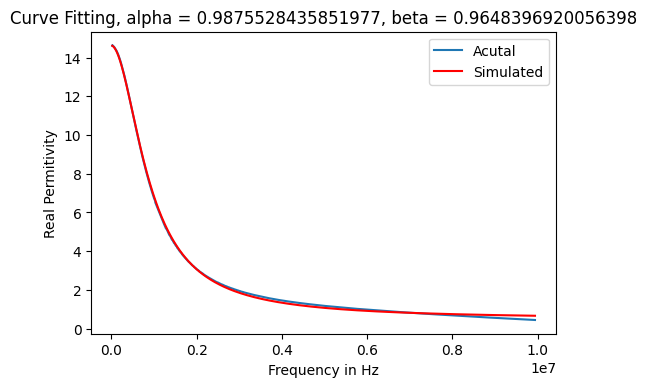

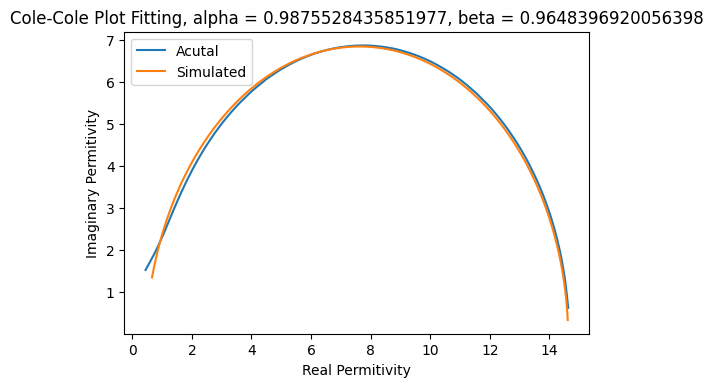

In [13]:
popt_HN_real, pcov_HN_real = curve_fit(complex_HN_real_array, DE.Frequency, (real_e-e_infi)/ds,p0=[1,1],bounds=(0,1))
print(popt_HN_real)
plt.figure(5,figsize=(6, 4), dpi=100, linewidth=0.1)
plt.ylabel("Real Permitivity")
plt.xlabel("Frequency in Hz")
plt.plot(DE.Frequency,real_e)
plt.plot(DE.Frequency, complex_HN_real_array(DE.Frequency, *popt_HN_real)*ds+e_infi, 'r-',label='fit: alpha=%5.3f, beta=%5.3f' % tuple(popt_HN_real))
plt.title("Curve Fitting, alpha = "+str(popt_HN_real[0])+", beta = "+str(popt_HN_real[1]))
plt.legend(['Acutal','Simulated'])
print("Cole-Cole Plot error = "+str(sq_error((popt_HN_real[0],popt_HN_real[1]))))

plt.figure(6,figsize=(6, 4), dpi=100, linewidth=0.1)
plt.xlabel("Real Permitivity")
plt.ylabel("Imaginary Permitivity")
sim_real = complex_HN_real_array(DE.Frequency,popt_HN_real[0],popt_HN_real[1])*ds+e_infi
sim_imag = complex_HN_imag_array(DE.Frequency,popt_HN_real[0],popt_HN_real[1])*ds
#sim_imag = complex_res_array(DE.Frequency,alpha,beta)*ds
plt.plot(DE.RealE,DE.ImagE)
plt.plot(sim_real,sim_imag)

plt.title("Cole-Cole Plot Fitting, alpha = "+str(popt_HN_real[0])+", beta = "+str(popt_HN_real[1]))
plt.legend(['Acutal','Simulated'])

      fun: 5820.271668960515
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.37735466e+02,  1.18234311e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([1.        , 0.44599457])
[1.         0.44599457]


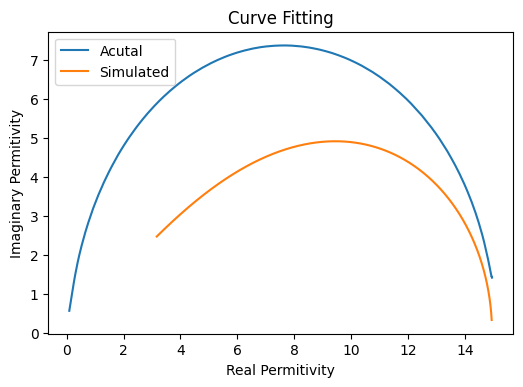

In [83]:
res=minimize(sq_error,[1,1],bounds=((0,1),(0,1),))
print(res)
if res.success:
    fitted_params = res.x
    print(fitted_params)
plt.figure(5,figsize=(6, 4), dpi=100, linewidth=0.1)
plt.xlabel("Real Permitivity")
plt.ylabel("Imaginary Permitivity")
sim_real = complex_res_real_array(DE.Frequency,fitted_params[0],fitted_params[1])*ds+e_infi
sim_imag = complex_res_array(DE.Frequency,fitted_params[0],fitted_params[1])*ds
#sim_imag = complex_res_array(DE.Frequency,alpha,beta)*ds
plt.plot(DE.RealE,DE.ImagE)
plt.plot(sim_real,sim_imag)

plt.title("Curve Fitting")
plt.legend(['Acutal','Simulated'])

# Plotting Results

In [ ]:
#Plotting the e_static vs temp
if not os.path.exists(output_path_DE+"/DielectricPropvsTemp") :
    os.mkdir (output_path_DE+"/DielectricPropvsTemp")
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Temperature in celcius")
plt.ylabel("Static Permittivity (e_static)")
plt.plot(result_DE.Temperature,result_DE.e_stat,'-o')

plt.title(name_of_LC+" e_static")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+name_of_LC+"_"+"e_static.jpg", dpi=300,bbox_inches='tight')
plt.show()

#Plotting the e_infi vs temp
if not os.path.exists(output_path_DE+"/DielectricPropvsTemp") :
    os.mkdir (output_path_DE+"/DielectricPropvsTemp")
plt.figure(3,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Temperature in celcius")
plt.ylabel("Permittivity at high freq (e_infi)")
plt.plot(result_DE.Temperature,result_DE.e_infi,'-o')

plt.title(name_of_LC+" e_infi")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+name_of_LC+"_"+"e_infi.jpg", dpi=300,bbox_inches='tight')
plt.show()

#Plotting the dielctric strength vs temp
if not os.path.exists(output_path_DE+"/DielectricPropvsTemp") :
    os.mkdir (output_path_DE+"/DielectricPropvsTemp")
plt.figure(4,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Temperature in celcius")
plt.ylabel("Dielectric Strength (e_stat - e_infi)")
plt.plot(result_DE.Temperature,result_DE.Dielectric_Strength,'-o')

plt.title(name_of_LC+" Dielectric_Strength")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+name_of_LC+"_"+"Dielectric_Strength.jpg", dpi=300,bbox_inches='tight')
plt.show()

#Plotting the Relaxation Frequency vs temp
if not os.path.exists(output_path_DE+"/DielectricPropvsTemp") :
    os.mkdir (output_path_DE+"/DielectricPropvsTemp")
plt.figure(5,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Temperature in celcius")
plt.ylabel("Relaxation Frequency in Hz")
plt.plot(result_DE.Temperature,result_DE.Relaxation_freq,'-o')

plt.title(name_of_LC+" Relaxation Frequency")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+name_of_LC+"_"+"Relaxation Frequency.jpg", dpi=300,bbox_inches='tight')
plt.show()


#Plotting the relaxation time vs temp
if not os.path.exists(output_path_DE+"/DielectricPropvsTemp") :
    os.mkdir (output_path_DE+"/DielectricPropvsTemp")
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Temperature in celcius")
plt.ylabel("Time in seconds")
plt.plot(result_DE.Temperature,result_DE.Relaxation_time,'-o')

plt.title(name_of_LC+" Relaxation_Time")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+name_of_LC+"_"+"Relaxation_Time.jpg", dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
#Plotting the log Relaxation Frequency vs 1/temp in K
if not os.path.exists(output_path_DE+"/DielectricPropvsTemp") :
    os.mkdir (output_path_DE+"/DielectricPropvsTemp")
plt.figure(5,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("1/T(K)")
plt.ylabel("Log of Relaxation Frequency")
plt.plot(1/(result_DE.Temperature+273),np.log(result_DE.Relaxation_freq),'-o')

# Set number of points in the isotropic region
points_to_avoid=2

#Fitting a linear line to the points
m,b=np.polyfit(1/(result_DE.Temperature.loc[points_to_avoid:]+273),np.log(result_DE.Relaxation_freq.loc[points_to_avoid:]),1)
plt.plot(1/(result_DE.Temperature+273),1/(result_DE.Temperature+273)*m +b)
for i in range(len(temps)):
    plt.annotate(temps[i],(1/(result_DE.Temperature[i]+273)+0.000002,np.log(result_DE.Relaxation_freq[i])))

#Calculate the activation energy
activation_energy=-m*scipy.constants.Boltzmann/scipy.constants.elementary_charge
print(str(activation_energy)+"eV")
plt.legend(['Actual','Best-Fit Line, Act. E ='+str(round(activation_energy,3))+"eV"])
plt.title(name_of_LC+" Activation Energy")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+name_of_LC+"_"+"Activation_Energy.jpg", dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
#Collection of Resistance vs Frequency for different temperatures
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Frequency in Log Scale")
plt.ylabel("Resistance")
plt.ylim([-10000,150000])
plt.title(name_of_LC+" Resistance for diff temps")
for temp in temps:
    DE=pd.read_csv(path_DE+"/"+temp+".CSV",skiprows=4)
    DE=DE[:-1]
    DE.columns=['Frequency','Capacitance','Dielectric_loss','Resistance','Reactance','Impedance']
    DE=DE.astype('float64')
    DE=DE[DE.Frequency>=1000]
    DE=DE[DE.Frequency<=10000000]
    plt.plot(np.log10(DE.Frequency),DE.Resistance)
plt.legend(temps,title="T-T_NI")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+name_of_LC+"_"+"Resistance for diff temps.jpg", dpi=300,bbox_inches='tight')
plt.show()
    

In [ ]:
#Collection of real_e vs Log Frequency for different temperatures
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Frequency in Log Scale")
plt.ylabel("Real Permittivity")
plt.ylim([-2,10])
plt.title(name_of_LC+" Real_e for diff temps")
for temp in temps:
    DE=pd.read_csv(path_DE+"/"+temp+".CSV",skiprows=4)
    DE=DE[:-1]
    DE.columns=['Frequency','Capacitance','Dielectric_loss','Resistance','Reactance','Impedance']
    DE=DE.astype('float64')
    DE=DE[DE.Frequency>=1000]
    DE=DE[DE.Frequency<=10000000]
    real_e=pd.Series(DE.Capacitance*thickness/epsilon/area)
    plt.plot(np.log10(DE.Frequency),real_e)
plt.legend(temps,title="T-T_NI")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+name_of_LC+"_"+"real_e for diff temps.jpg", dpi=300,bbox_inches='tight')
plt.show()
    

In [ ]:
#Collection of Reactance vs Frequency for different temperatures
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Frequency in Log Scale")
plt.ylabel("Reactance")
plt.ylim([-300000,10000])
plt.title(name_of_LC+" Reactance for diff temps")
for temp in temps:
    DE=pd.read_csv(path_DE+"/"+temp+".CSV",skiprows=4)
    DE=DE[:-1]
    DE.columns=['Frequency','Capacitance','Dielectric_loss','Resistance','Reactance','Impedance']
    DE=DE.astype('float64')
    DE=DE[DE.Frequency>=1000]
    DE=DE[DE.Frequency<=10000000]
    plt.plot(np.log10(DE.Frequency),DE.Reactance)
plt.legend(temps,title="T-T_NI")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+name_of_LC+"_"+"Reactance for diff temps.jpg", dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
#Collection of imag_e vs Log Frequency for different temperatures
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Frequency in Log Scale")
plt.ylabel("Imaginary Permittivity")
plt.title(name_of_LC+" Imag_e for diff temps")
plt.ylim([-7,12.5])
for temp in temps:
    DE=pd.read_csv(path_DE+"/"+temp+".CSV",skiprows=4)
    DE=DE[:-1]
    DE.columns=['Frequency','Capacitance','Dielectric_loss','Resistance','Reactance','Impedance']
    DE=DE.astype('float64')
    DE=DE[DE.Frequency>=1000]
    DE=DE[DE.Frequency<=10000000]
    real_e=pd.Series(DE.Capacitance*thickness/epsilon/area)
    imag_e =real_e*DE.Dielectric_loss
    plt.plot(np.log10(DE.Frequency),imag_e)
plt.legend(temps,title="T-T_NI")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+name_of_LC+"_"+"image for diff temps.jpg", dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
#Collection of uncut Cole-Cole Plots
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Real Permittivity")
plt.ylabel("Imaginary Permittivity")
plt.title(name_of_LC+" Cole-Cole for diff temps")
for temp in temps:
    DE=pd.read_csv(path_DE+"/"+temp+".CSV",skiprows=4)
    DE=DE[:-1]
    DE.columns=['Frequency','Capacitance','Dielectric_loss','Resistance','Reactance','Impedance']
    DE=DE.astype('float64')
    DE=DE[DE.Frequency>=1000]
    DE=DE[DE.Frequency<=10000000]
    real_e=pd.Series(DE.Capacitance*thickness/epsilon/area)
    imag_e =real_e*DE.Dielectric_loss
    plt.plot(real_e,imag_e)

plt.legend([(base_temp+int(i)) for i in temps])
plt.savefig(output_path_DE+"/Cole-Cole_Plot/"+name_of_LC+"_"+"Cole-Cole for diff temps.jpg", dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
#Collection of Cole-Cole Plots of Impedence
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Resistance")
plt.ylabel("Absolute Reactance")
plt.ylim([0,300000])
plt.xlim([0,150000])
plt.title(name_of_LC+" Cole-Cole of impedence for diff temps")
for temp in temps:
    DE=pd.read_csv(path_DE+"/"+temp+".CSV",skiprows=4)
    DE=DE[:-1]
    DE.columns=['Frequency','Capacitance','Dielectric_loss','Resistance','Reactance','Impedance']
    DE=DE.astype('float64')
    DE=DE[DE.Frequency>=1000]
    DE=DE[DE.Frequency<=10000000]
    plt.plot(DE.Resistance,-DE.Reactance)

plt.legend(temps,title="T-T_NI")
plt.savefig(output_path_DE+"/Cole-Cole_Plot/"+name_of_LC+"_"+"Cole-Cole of impedence for diff temps.jpg", dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
#Plotting Conductivity for pure
name_of_LC="Pure"# Change this to show type of LC
thickness= 6E-6 #in Metres
area=64E-6 #in Metres^2
empty_c=94E-12 #in Farad
temps=['+2','-1','-2','-3','-5','-7','-9','-11']
base_temp=45.2
path_DE="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/Pure"
if not os.path.exists(path_DE + "/Analysis") :
    os.mkdir (path_DE + "/Analysis")
output_path_DE=path_DE+"/Analysis"

plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Frequency on Log scale")
plt.ylabel("Conductivity in ohm^-1 m^-1")
plt.ylim([-0.0001,0.003])
plt.title(name_of_LC+" Conductivity for diff temps")
pure_max=[]
pure_first=[]
for temp in temps:
    DE=pd.read_csv(path_DE+"/"+temp+".CSV",skiprows=4)
    DE=DE[:-1]
    DE.columns=['Frequency','Capacitance','Dielectric_loss','Resistance','Reactance','Impedance']
    DE=DE.astype('float64')
    DE=DE[DE.Frequency>=1000]
    DE=DE[DE.Frequency<=10000000]
    cond = 1/DE.Impedance*thickness/area
    pure_first+=[cond.iloc[0]]
    pure_max+=[max(cond)]
    plt.plot(np.log10(DE.Frequency),cond)
plt.legend(temps,title="T-T_NI")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+name_of_LC+"_"+"Conductivity for diff temp.jpg", dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
#Plotting Conductivity for doped
name_of_LC="Doped"# Change this to show type of LC
thickness= 6.5E-6 #in Metres
area=70E-6 #in Metres^2
empty_c=102E-12 #in Farad
temps=['+5','+2','-1','-2','-3','-5','-7','-9','-11','-13']
base_temp=44.2
path_DE="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/Doped"
if not os.path.exists(path_DE + "/Analysis") :
    os.mkdir (path_DE + "/Analysis")
output_path_DE=path_DE+"/Analysis"
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Frequency on Log scale")
plt.ylabel("Conductivity in ohm^-1 m^-1")
plt.ylim([-0.0001,0.003])
plt.title(name_of_LC+" Conductivity for diff temps")
doped_max=[]
doped_first=[]
for temp in temps:
    DE=pd.read_csv(path_DE+"/"+temp+".CSV",skiprows=4)
    DE=DE[:-1]
    DE.columns=['Frequency','Capacitance','Dielectric_loss','Resistance','Reactance','Impedance']
    DE=DE.astype('float64')
    DE=DE[DE.Frequency>=1000]
    DE=DE[DE.Frequency<=10000000]
    cond = 1/DE.Impedance*thickness/area
    doped_first+=[cond.iloc[0]]
    doped_max+=[max(cond)]
    plt.plot(np.log10(DE.Frequency),cond)
plt.legend(temps,title="T-T_NI")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+name_of_LC+"_"+"Conductivity for diff temp.jpg", dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
#Plotting the max and 1kHz conductivity vs temp
if not os.path.exists(output_path_DE+"/DielectricPropvsTemp") :
    os.mkdir (output_path_DE+"/DielectricPropvsTemp")
temps_doped=['+5','+2','-1','-2','-3','-5','-7','-9','-11','-13']
temps_pure=['+2','-1','-2','-3','-5','-7','-9','-11']
base_pure=45.2
base_doped=44.2
temps_pure=[int(tem) for tem in temps_pure]
temps_doped=[int(tem) for tem in temps_doped]

plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("T-T_NI")
plt.ylabel("Conductivity in ohm-1 m-1")
plt.plot(temps_pure,pure_first,'-o')
plt.plot(temps_doped,doped_first,'-o')
plt.legend(['Pure','Doped'])
plt.title("Conductivity at 1kHz")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+"Conductivity at 1kHz.jpg", dpi=300,bbox_inches='tight')
plt.show()

plt.figure(3,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("T-T_NI")
plt.ylabel("Conductivity in ohm-1 m-1")
plt.plot(temps_pure,pure_max,'-o')
plt.plot(temps_doped,doped_max,'-o')
plt.legend(['Pure','Doped'])
plt.title("Conductivity at peak")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+"Conductivity at peak.jpg", dpi=300,bbox_inches='tight')
plt.show()


In [ ]:
#Plotting sigma for pure
name_of_LC="Pure"# Change this to show type of LC
thickness= 6E-6 #in Metres
area=64E-6 #in Metres^2
empty_c=94E-12 #in Farad
temps=['+2','-1','-2','-3','-5','-7','-9','-11']
base_temp=45.2
path_DE="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/Pure"
if not os.path.exists(path_DE + "/Analysis") :
    os.mkdir (path_DE + "/Analysis")
output_path_DE=path_DE+"/Analysis"
epsilon_0=8.854e-12
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Frequency on Log scale")
plt.ylabel("Sigma")
plt.ylim([-0.003,0.003])
plt.title(name_of_LC+" Sigma for diff temps")
pure_max=[]
pure_first=[]
for temp in temps:
    DE=pd.read_csv(path_DE+"/"+temp+".CSV",skiprows=4)
    DE=DE[:-1]
    DE.columns=['Frequency','Capacitance','Dielectric_loss','Resistance','Reactance','Impedance']
    DE=DE.astype('float64')
    DE=DE[DE.Frequency>=1000]
    DE=DE[DE.Frequency<=10000000]
    real_e=pd.Series(DE.Capacitance*thickness/epsilon/area)
    imag_e =real_e*DE.Dielectric_loss
    sigma = 2*pi*DE.Frequency*epsilon_0*imag_e
    pure_first+=[sigma.iloc[0]]
    pure_max+=[max(sigma)]
    plt.plot(np.log10(DE.Frequency),sigma)
plt.legend(temps,title="T-T_NI")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+name_of_LC+"_"+"Sigma for diff temp.jpg", dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
#Plotting sigma for doped
name_of_LC="Doped"# Change this to show type of LC
thickness= 6.5E-6 #in Metres
area=70E-6 #in Metres^2
empty_c=102E-12 #in Farad
temps=['+5','+2','-1','-2','-3','-5','-7','-9','-11','-13']
base_temp=44.2
path_DE="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/Doped"
if not os.path.exists(path_DE + "/Analysis") :
    os.mkdir (path_DE + "/Analysis")
output_path_DE=path_DE+"/Analysis"
plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("Frequency on Log scale")
plt.ylabel("Sigma")
plt.ylim([-0.003,0.003])
plt.title(name_of_LC+" Sigma for diff temps")
doped_max=[]
doped_first=[]
for temp in temps:
    DE=pd.read_csv(path_DE+"/"+temp+".CSV",skiprows=4)
    DE=DE[:-1]
    DE.columns=['Frequency','Capacitance','Dielectric_loss','Resistance','Reactance','Impedance']
    DE=DE.astype('float64')
    DE=DE[DE.Frequency>=1000]
    DE=DE[DE.Frequency<=10000000]
    real_e=pd.Series(DE.Capacitance*thickness/epsilon/area)
    imag_e =real_e*DE.Dielectric_loss
    sigma = 2*pi*DE.Frequency*epsilon_0*imag_e
    doped_first+=[sigma.iloc[0]]
    doped_max+=[max(sigma)]
    plt.plot(np.log10(DE.Frequency),sigma)
plt.legend(temps,title="T-T_NI")
plt.savefig(output_path_DE+"/DielectricPropvsTemp/"+name_of_LC+"_"+"Sigma for diff temp.jpg", dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
#Plotting the max and 1kHz sigma vs 1/temp
if not os.path.exists(output_path_DE+"/DielectricPropvsTemp") :
    os.mkdir (output_path_DE+"/DielectricPropvsTemp")
temps_doped=['+5','+2','-1','-2','-3','-5','-7','-9','-11','-13']
temps_pure=['+2','-1','-2','-3','-5','-7','-9','-11']
base_pure=45.2
base_doped=44.2
temps_pure_inv=[1/(float(tem)+base_pure+273) for tem in temps_pure]
temps_doped_inv=[1/(float(tem)+base_doped+273) for tem in temps_doped]
#sigma

plt.figure(4,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("1/T (K)")
plt.ylabel("Sigma")
plt.plot(temps_pure_inv,pure_first,'-o')
plt.plot(temps_doped_inv,doped_first,'-o')
plt.legend(['Pure','Doped'])
plt.title("Sigma at 1kHz vs T inverse")
plt.savefig("/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/"+"Sigma at 1kHz vs T inverse.jpg", dpi=300,bbox_inches='tight')
plt.show()

plt.figure(5,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("1/T (K)")
plt.ylabel("Sigma")
plt.plot(temps_pure_inv,pure_max,'-o')
plt.plot(temps_doped_inv,doped_max,'-o')
plt.legend(['Pure','Doped'])
plt.title("Sigma at peak vs T inverse")
plt.savefig("/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/"+"Sigma at peak vs T inverse.jpg", dpi=300,bbox_inches='tight')
plt.show()

plt.figure(6,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("T-T_NI")
plt.ylabel("Sigma")
plt.plot([(int(i)) for i in temps_pure],pure_first,'-o')
plt.plot([(int(i)) for i in temps_doped],doped_first,'-o')
plt.legend(['Pure','Doped'])
plt.title("Sigma at 1kHz vs T")
plt.savefig("/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/"+"Sigma at 1kHz vs T.jpg", dpi=300,bbox_inches='tight')
plt.show()

plt.figure(7,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("T-T_NI")
plt.ylabel("Sigma")
plt.plot([(int(i)) for i in temps_pure],pure_max,'-o')
plt.plot([(int(i)) for i in temps_doped],doped_max,'-o')
plt.legend(['Pure','Doped'])
plt.title("Sigma at peak vs T")
plt.savefig("/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/"+"Sigma at peak vs T.jpg", dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
pure_path_DE="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/Pure/Analysis"
Pure_DE=pd.read_csv(pure_path_DE+"/Dielectric_Data.csv")

doped_path_DE="/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/Doped/Analysis"
Doped_DE=pd.read_csv(doped_path_DE+"/Dielectric_Data.csv")

plt.figure(2,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("T-T_NI")
plt.ylabel("Relaxation Frequency in Hz")
plt.plot(Pure_DE.Temperature-base_pure,Pure_DE.Relaxation_freq,'-o')
plt.plot(Doped_DE.Temperature-base_doped,Doped_DE.Relaxation_freq,'-o')
plt.legend(['Pure','Doped'])
plt.title(" Relaxation Frequency vs Temp for Pure and Doped")
plt.savefig("/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/"+"Relaxation_Frequency_vs_Temp_for_Pure_and_Doped.jpg", dpi=300,bbox_inches='tight')
plt.show()

plt.figure(3,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("T-T_NI")
plt.ylabel("Relaxation Time in seconds")
plt.plot(Pure_DE.Temperature-base_pure,Pure_DE.Relaxation_time,'-o')
plt.plot(Doped_DE.Temperature-base_doped,Doped_DE.Relaxation_time,'-o')
plt.legend(['Pure','Doped'])
plt.title(" Relaxation Time vs Temp for Pure and Doped")
plt.savefig("/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/"+"Relaxation_Time_vs_Temp_for_Pure_and_Doped.jpg", dpi=300,bbox_inches='tight')
plt.show()

plt.figure(4,figsize=(12, 8), dpi=100, linewidth=0.1)
plt.xlabel("T-T_NI")
plt.ylabel("Dielectric Strength")
plt.plot(Pure_DE.Temperature-base_pure,Pure_DE.Dielectric_Strength,'-o')
plt.plot(Doped_DE.Temperature-base_doped,Doped_DE.Dielectric_Strength,'-o')
plt.legend(['Pure','Doped'])
plt.title(" Dielectric Strength vs Temp for Pure and Doped")
plt.savefig("/home/avinash/Desktop/Projects/Liquid_Crystal_Analysis/data/Batch4/Dielectric-spectroscopy/"+"Dielectric_Strength_vs_Temp_for_Pure_and_Doped.jpg", dpi=300,bbox_inches='tight')
plt.show()

# Analysing properties of the Liquid Crystal

In [ ]:
#Setting up dataframe for recording derived properties 
properties=pd.DataFrame(columns = ['Property', 'Value', 'Units'])

In [ ]:
#If the above Property is fine, append the property to list of properties
properties=properties.append({'Property':prop, 'Value':value, 'Units':units},ignore_index=True)
properties.tail()

In [ ]:
# If all the properties are fine, write out the properties to a csv file
properties.to_csv(output_path+"/"+"Derived_Properties.csv", index=False)

In [ ]:
#Calculating K from Threshold Voltage
#K depends on temperature
k_by_dielectric_anisotropy=(vth*2/pi)**2*epsilon
print("Combined elastic constant K divided by dielectric anisotropy "+"at temp "+str(temp)+" celcius = "+str(k_by_dielectric_anisotropy))

In [ ]:
#Calulating Rotational Viscocity by Dielectric Anisotrpy from Rise Time
gamma_by_DA=[]
for i in range(21,28):
    gamma_by_DA.append(results['Rise Time'][i]*epsilon*((results['Applied Voltage'][i])**2-vth**2)/thickness**2)
    print(results['Applied Voltage'][i],gamma_by_DA[i-21])

In [ ]:
#Comparing Visco Elasitc Ratios
for i in range(21,28):
    print(results['Visco-Elastic Ratio'][i],gamma_by_DA[i-21]/k_by_dielectric_anisotropy,results['Visco-Elastic Ratio'][i]-gamma_by_DA[i-21]/k_by_dielectric_anisotropy)